# Simple moving MNIST for convection

From https://keras.io/examples/vision/conv_lstm/

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [2]:
devices = tf.config.list_physical_devices('GPU')
print(len(devices))
print(devices)
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(
  cuda_only=False, min_cuda_compute_capability=None
)

1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

### Utility functions

In [3]:
def download_moving_mnist(n_samples=None):
  # Download and load the dataset.
  fpath = tf.keras.utils.get_file(
      "moving_mnist.npy",
      "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
  )
  dataset = np.load(fpath) 
  if n_samples is not None:
    dataset = dataset[:, 0:n_samples, :, :]
  # Swap the axes representing the number of frames and number of data samples.
  dataset = np.swapaxes(dataset, 0, 1)
  # Add a channel dimension since the images are grayscale.
  dataset = np.expand_dims(dataset, axis=-1)
  return dataset

In [4]:
def split_dataset(dataset, test=0.2, random_state=None, shuffle=False):
  splitting = train_test_split(
      dataset,
      test_size=test,
      train_size=None,
      random_state=random_state,
      shuffle=shuffle)
  return splitting


In [5]:
def normalise_dataset(dataset, factor=1./255.):
  return dataset*factor

In [6]:
def create_shifted_frames(data):
    x = data[:, 0:data.shape[1] - 1, :, :]
    y = data[:, 1:data.shape[1], :, :]
    return x, y

## Data Viz functions

In [7]:
def plot_frames(dataset):
    fig, axes = plt.subplots(4, 5, figsize=(10, 8))

    # Plot each of the sequential images for one random data example.
    data_choice = np.random.choice(range(len(dataset)), size=1)[0]
    for idx, ax in enumerate(axes.flat):
        ax.imshow(np.squeeze(dataset[data_choice][idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 1}")
        ax.axis("off")

    # Print information and display the figure.
    print(f"Displaying frames for example {data_choice}.")
    plt.show()

### Code

In [8]:
dataset = download_moving_mnist(n_samples=2000)
dataset = normalise_dataset(dataset)

819216384/819200096 [==============================] - 49s 0us/step


In [9]:
dataset.shape
# (10000, 20, 64, 64, 1)
# (samples, frames, width, height, # of channels)

(2000, 20, 64, 64, 1)

In [10]:
tr_dataset, val_dataset = split_dataset(dataset, test=0.2, random_state=1)
print(f'Length of training dataset: {len(tr_dataset)}')
print(f'Length of validation dataset: {len(val_dataset)}')

Length of training dataset: 1600
Length of validation dataset: 400


In [11]:
tr_x, tr_y = create_shifted_frames(tr_dataset)
val_x, val_y = create_shifted_frames(val_dataset)
print(f'Training dataset shapes: {tr_x.shape}, {tr_y.shape}')
print(f'Validation dataset shapes: {val_x.shape}, {val_y.shape}')

Training dataset shapes: (1600, 19, 64, 64, 1), (1600, 19, 64, 64, 1)
Validation dataset shapes: (400, 19, 64, 64, 1), (400, 19, 64, 64, 1)


Displaying frames for example 1314.


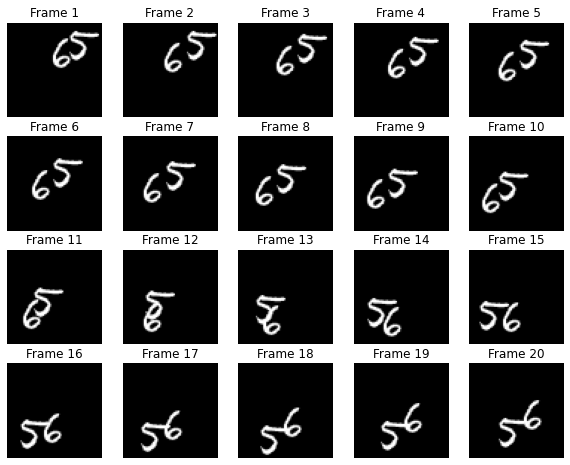

In [12]:
plot_frames(tr_dataset)

### Model Construction

In [13]:
tr_x.shape
tr_x.shape[2:]

(64, 64, 1)

In [14]:
inp = tf.keras.layers.Input(shape=(None, *tr_x.shape[2:]))
# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = tf.keras.layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = tf.keras.layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

In [15]:
model = tf.keras.models.Model(inp, x)
model.compile(
    loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(),
)

In [ ]:
# config = tf.ConfigProto(gpu_options= tf.GPUOptions(allow_growth=True))
# allow_growth=True is the important part here

# Define some callbacks to improve training.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 10
batch_size = 5

# Fit the model to the training data.
model.fit(
    tr_x,
    tr_y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(val_x, val_y),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
320/320 [==============================] - 823s 3s/step - loss: 0.1731 - val_loss: 0.3870 - lr: 0.0010
Epoch 2/10
320/320 [==============================] - 805s 3s/step - loss: 0.1675 - val_loss: 0.3300 - lr: 0.0010
Epoch 3/10
320/320 [==============================] - 804s 3s/step - loss: 0.1744 - val_loss: 0.2118 - lr: 0.0010
Epoch 4/10
308/320 [===========================>..] - ETA: 27s - loss: 0.1703

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()